In [206]:
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress, TruncBondThresh  

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

using Revise

include("tensor_builder.jl")
include("efficient_observables.jl")
include("calculo_observables.jl")
include("monte_carlo_swap.jl")
include("parallel_monte_carlo_Glauber.jl")

compute_marginal_magnetization_parallel

In [3]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title="Marginal expectation per spin over steps",
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

## Pruebas

In [4]:
N = 50
t = 100
max_bound = 5

# TensotTrain de transición simpmle
A = build_transition_tensorchain(transition_rate, random_params(N))
# TensorTrain de probabilidad tiempo t simple
B_t = tensor_b_t(A, random_P0(N), t, max_bound)

# TensorTrain de transición paralela
A_plus = parallel_transition_tensor_train(transition_rate, parallel_random_params(N))

# TensorTrain de probabilidad tiempo t paralela con cadenas independientes
B_t_plus = tensor_b_t(A_plus, random_P0(N, 4), t, max_bound)

# TensorTrain de probabilidad tiempo t paralela con condiciones iniciales fijas
B_t_plus_fixed = tensor_b_t(A_plus, parallel_random_P0_fixed(N), t, max_bound)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[0.07498766990576772 0.1501958467237504 0.2574814296318949 -0.5157173158921725;;; 0.2574815553617368 0.515717253117896 -0.07498911812926448 0.150195123670844;;; 0.15019497233685536 -0.07498632805892057 0.5157175705425519 0.25748182042608614;;; 0.5157175077720435 -0.25748194615347225 -0.1501942492836218 -0.0749877762826304], [0.5143944888919953 -0.23704543113652826 … -0.07502553115929093 -0.032245228563362406; -0.05494171533732601 0.054028329409203955 … 0.01712372217321539 0.021794975637708432; -0.025403303869156086 0.01171871437544367 … 0.017583820111506228 -0.47574400839805725; -0.0027133118344978557 0.002669468777850727 … 0.004017642854118 -0.05026128636406132;;; 0.09841579396807436 -0.045323591742843346 … 0.13316843605170262 0.22523924386157215; -0.010511273835836358 0.01033382182321069 … -0.030341623484152286 -0.020571070507231757; 0.13230413930917406 -0.06091888623845096 … 0.19601800288751708 -0.12264627505928044; 0.014131249

In [5]:
println("Suma total de B_t: ", sum_one_check(B_t))
println("Suma total de B_t_plus: ", sum_one_check(B_t_plus))
println("Suma total de B_t_plus_fixed: ", sum_one_check(B_t_plus_fixed),"\n")
println("Distribución marginal en el sitio 10 de B_t: ", marginal_distribution(B_t, 10))
println("Distribución marginal en el sitio 10 de B_t_plus: ", marginal_distribution(B_t_plus, 10))
println("Distribución marginal en el sitio 10 de B_t_plus_fixed: ", marginal_distribution(B_t_plus_fixed, 10),"\n")
println("Valor esperado marginal en el sitio 10 de B_t: ", marginal_expected_value_simple(B_t, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus: ", marginal_expected_value_parallel(B_t_plus, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus_fixed: ", marginal_expected_value_parallel(B_t_plus_fixed, 10))

Suma total de B_t: 0.9999999999999983
Suma total de B_t_plus: 0.9999999999999999
Suma total de B_t_plus_fixed: 0.9999999999999902

Distribución marginal en el sitio 10 de B_t: [0.41868225185215413, 0.5813177481478445]
Distribución marginal en el sitio 10 de B_t_plus: [0.37229473405471136, 0.22933375554606678, 0.24653966693731302, 0.1518318434619079]
Distribución marginal en el sitio 10 de B_t_plus_fixed: [0.3723164748232976, 0.22931305466971189, 0.24655284836821473, 0.15181762213876648]

Valor esperado marginal en el sitio 10 de B_t: 0.1626354962956904
Valor esperado marginal en el sitio 10 de B_t_plus: (-0.23766880198404972, -0.20325697920155728)
Valor esperado marginal en el sitio 10 de B_t_plus_fixed: (-0.237738646383034, -0.2032590589860283)


## Parallel Dynamic

In [7]:
N = 10                                 # Número de espines
T = 100                               # Número de iteraciones (tiempo)
params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0
P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallel( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0)
result_mc = run_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)

mag_mc_time = compute_marginal_magnetization_parallel(result_mc)   # magnetización de cada espín por instante de tiempo

# TensorTrains
max_bound = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_plus_fixed = tensor_b_t_over_time(A_plus, P0, T, max_bound)

mag_tt_time = [marginal_ev_parallel_system(B_t_plus_fixed[k]) for k in 1:T]

print("done")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


done

In [8]:
# params = (
#     N = 10,
#     beta_1 = 0.5,
#     beta_2 = 1.0,
#     j_vector = randn(N-1),
#     h_vector = randn(N),
#     p0 = 0.1
# )

In [9]:
print(params)

(N = 10, beta_1 = 0.21429175391249544, beta_2 = 0.8479049166645864, j_vector = [-0.20460207869451108, 0.6598933745618718, 0.642908024876141, -0.056364428814493106, 0.277869869883804, -0.25321235309703916, -0.6906338601239008, 0.9264927803862801, -0.09979268266697261], h_vector = [0.0679712029784425, -0.9647344612411008, -0.7603938544354816, -0.7383719673543485, 0.14145417632055324, -0.6031431814723951, -0.3555868389617105, 0.3814183583886972, 0.5038581094017633, 0.7821642946862248], p0 = 0.35586505550214964)

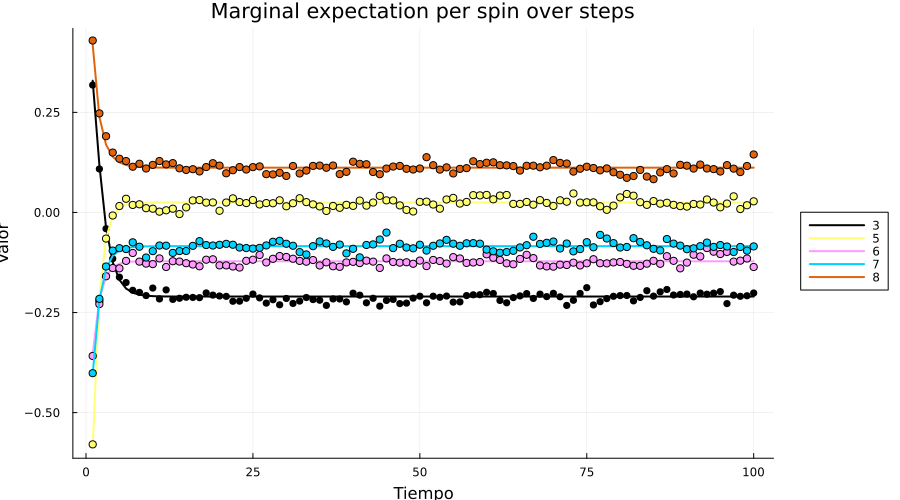

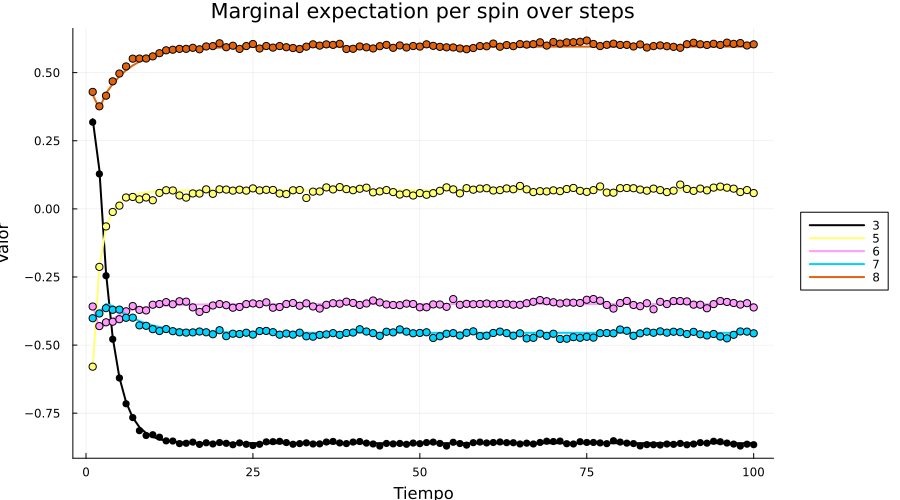

In [10]:
numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

for system in 1:2
    Sdots = mag_mc_time[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

In [11]:
system_of_correlations = []
for t in 1:10
    push!(system_of_correlations, correlation_between_chains(B_t_plus_fixed[t]))
end

print(correlation_between_chains(B_t_plus_fixed[1]), "\n", covariance_between_chains(B_t_plus_fixed[1]), "\n")

[0.9999999999999999, 0.9999999999999998, 0.9999999999999996, 0.9999999999999991, 0.9999999999999993, 0.9999999999999993, 0.9999999999999998, 0.9999999999999993, 0.9999999999999998, 0.9999999999999997]
[0.801068721215226, 0.838650247036664, 0.8916797487695356, 0.3885811630819861, 0.6596633694469096, 0.8750048467062542, 0.8369579372675677, 0.8244996517653544, 0.9991296007550237, 0.6190063231017229]


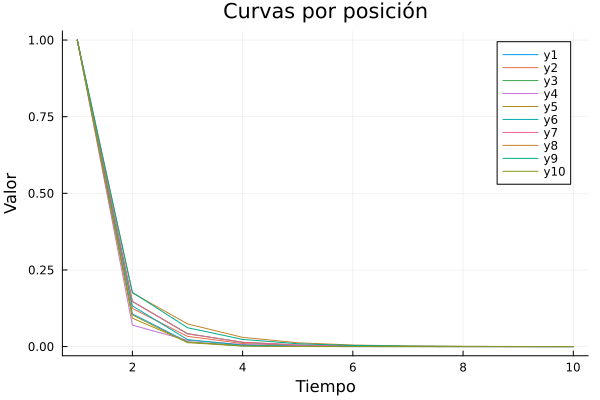

In [12]:
using Plots

# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")

### Some index references

    ( X  Y)

1-  (-1 -1)

2-  ( 1 -1)

3-  (-1  1)

4-  ( 1  1)

mag_tt_time[time][spin][X-Y]

mag_mc_time[X-Y][spin,time]

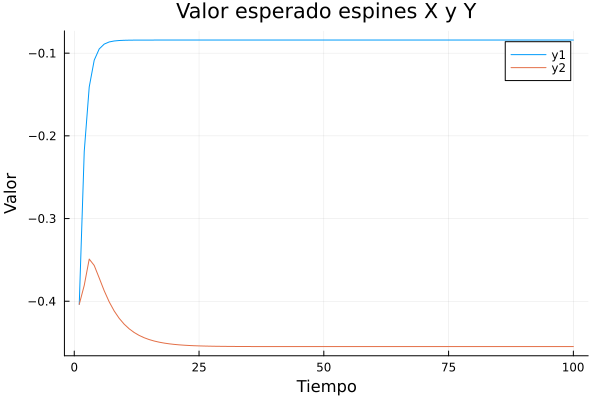

In [13]:
spin_X_ev_time = []
spin_Y_ev_time = []
spin_number = 7
for t in 1:100
    evs_X = mag_tt_time[t][spin_number][1]  # Valor esperado del espín X en el tiempo t
    evs_Y = mag_tt_time[t][spin_number][2]  # Valor esperado del espín Y en el tiempo t
    push!(spin_X_ev_time, evs_X)
    push!(spin_Y_ev_time, evs_Y)
end
mat_ev = hcat(spin_X_ev_time, spin_Y_ev_time)'  # Convierte a matriz 2 x T
plot(mat_ev', legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Valor esperado espines X y Y")  

## Swap

In [14]:
N = 10                                 # Número de espines
# params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0

P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y


10-element Vector{Vector{Float64}}:
 [0.4050291376367905, 0.0, 0.0, 0.5949708623632094]
 [0.42992073610994835, 0.0, 0.0, 0.5700792638900516]
 [0.7161114169880011, 0.0, 0.0, 0.2838885830119989]
 [0.7782741080857515, 0.0, 0.0, 0.22172589191424855]
 [0.07532894508618551, 0.0, 0.0, 0.9246710549138146]
 [0.35843545666820276, 0.0, 0.0, 0.6415645433317972]
 [0.527358313162019, 0.0, 0.0, 0.4726416868379811]
 [0.4283786088792809, 0.0, 0.0, 0.571621391120719]
 [0.5379116577339932, 0.0, 0.0, 0.46208834226600676]
 [0.6601140009138788, 0.0, 0.0, 0.3398859990861212]

In [108]:
T = 100                               # Número de iteraciones (tiempo)

# params = (
#     N = 10,
#     beta_1 = 0.01,
#     beta_2 = 100.0,
#     j_vector = fill(1, N-1),
#     h_vector = fill(0,N),
#     p0 = 0.1
# )
  # Número de iteraciones (tiempo)
params = parallel_random_params(N)  

s = 0.2

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallelSwap( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0, s)
result_mc_swap = run_swap_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)

mag_mc_time_swap = compute_marginal_magnetization_parallel(result_mc_swap)   # magnetización de cada espín por instante de tiempo

# TensorTrains
bond = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_swap_fixed = tensor_b_t_swap(A_plus, P0, T, bond, s, true)
# B_t_parallel_fixed = tensor_b_t_over_time(A_plus, P0, T, bond)

mag_tt_time_swap = [marginal_ev_parallel_system(B_t_swap_fixed[k]) for k in 1:T]

print("done")



Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


done

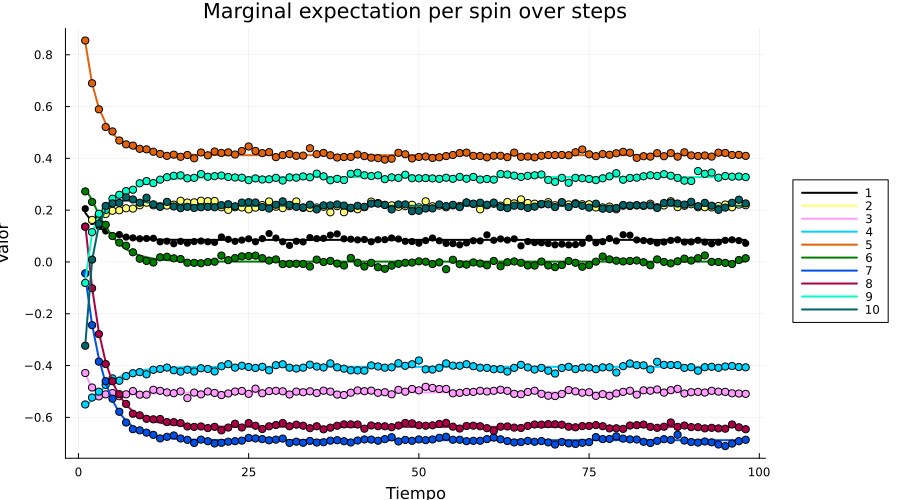

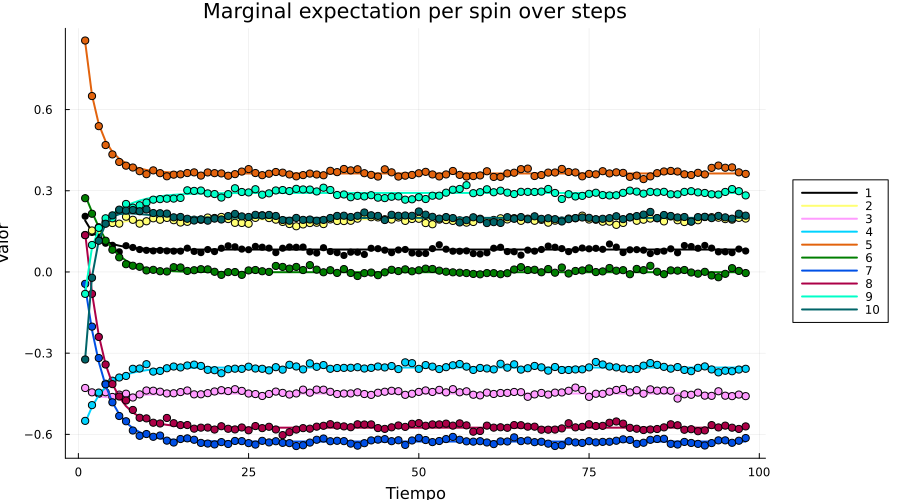

In [109]:
mag_tt_time_swap = [marginal_ev_parallel_system(B_t_swap_fixed[k]) for k in 1:T]

numbers_of_spins = 10
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

T=98
for system in 1:2
    Sdots = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

In [78]:
# mag_tt_time_swap = [marginal_ev_parallel_system(B_t_swap_fixed[k]) for k in 1:T]
# mag_tt_time_parallel = [marginal_ev_parallel_system(B_t_parallel_fixed[k]) for k in 1:T]

# numbers_of_spins = 5
# lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
# str_lista = string.(lista_of_spins)


# for system in 1:2
#     Sdots_ = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

#     Slines = zeros(size(Sdots_))                        # N x T
#     for k in 1:T
#         for j in 1:length(lista_of_spins)
#             spin_idx = lista_of_spins[j]
#             Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
#         end
#     end

#     Sdots = zeros(size(Sdots_))                        # N x T
#     for k in 1:T
#         for j in 1:length(lista_of_spins)
#             spin_idx = lista_of_spins[j]
#             Sdots[j, k] = mag_tt_time_parallel[k][spin_idx][system]
#         end
#     end

#     times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
#     p = plot_two_Ntuples(times, Sdots, Sdots_;
#                            site_labels = str_lista,
#                            savepath="sextuples_compare.png")
#     display(p)
# end

In [18]:
system_of_correlations = []
for t in 1:100
    push!(system_of_correlations, correlation_between_chains(B_t_swap_fixed[t]))
end

print(correlation_between_chains(B_t_swap_fixed[1]), "\n", covariance_between_chains(B_t_swap_fixed[1]), "\n")

[0.9999999999999999, 0.9999999999999997, 0.9999999999999999, 0.9999999999999997, 0.9999999999999996, 0.9999999999999997, 0.9999999999999999, 0.9999999999999998, 0.9999999999999998, 0.9999999999999999]
[0.9639221412079532, 0.9803555870905138, 0.8131834217897531, 0.690254083076318, 0.2786179804735518, 0.9198379202850386, 0.9970060908037155, 0.9794815053357319, 0.994250824831442, 0.8974540268454015]


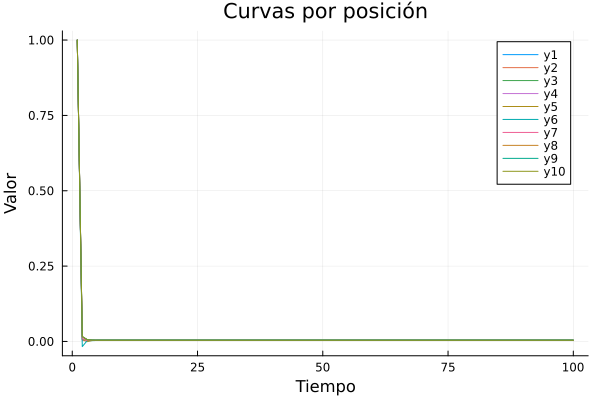

In [19]:
using Plots

# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")

In [217]:
system_description_ = system_description(B_t_swap_fixed[2],params)

(Any[[0.2532127328885036, 0.17257510933076958, 0.16926156652237545, 0.40495059125834953], [0.25615458819101056, 0.17162051862272798, 0.16646839146010942, 0.40575650172615035], [0.5987263422350224, 0.1270944532672102, 0.14468157779455268, 0.12949762670321277], [0.62472093282707, 0.12436243493256392, 0.1418502226074326, 0.10906640963293188], [0.04919477671727515, 0.12413379080429604, 0.10627060324979519, 0.7204008292286319], [0.21168046307705052, 0.17741188659678817, 0.16889022413001736, 0.4420174261961426], [0.4495182017043596, 0.15749268883347284, 0.17116284248996919, 0.22182626697219707], [0.37122919113423214, 0.1674023393510149, 0.178017418509886, 0.28335105100486535], [0.2778441357353279, 0.1772549800232133, 0.1668274611228624, 0.378073423118595], [0.3194756770677462, 0.1897641738700081, 0.17754188771312443, 0.31321826134911984]], Any[[0.032145549556484694 0.037976478197504514 0.03352626390250474 0.1495644412320097; 0.03937156932114663 0.031379252656945834 0.030313952689663377 0.071

In [221]:
system_description_[6]

(-2.1271315535970317, -1.893754394057216)